# Epic Chat Chain by the Numbers

For this analysis, I pulled down the chat history back to February 2017. Parsed it out, and ran some stats.

Inspired by: https://github.com/mskeving/email-analysis

First, parse out the textfile data into a useable format

In [1]:
from datetime import datetime, timedelta
from random import randint
import warnings

import pytz
import pandas as pd
import matplotlib.pyplot as plt


warnings.simplefilter('ignore')
%matplotlib inline

DATE_FORMAT = '%a, %m/%d/%Y'
TIME_FORMAT = '%I:%M %p'
PACIFIC_TIME = pytz.timezone('US/Pacific')
TIME_ZERO = datetime(1900, 1, 1)

with open('[LINE] Chat in Epic Chat Chain.txt', 'r') as f:
    raw_text = f.read()
    
days = raw_text.split('\n\n')

columns = ['timestamp', 'name', 'text']
records = pd.DataFrame()

# days[0] is header

for day in days[1:]:
    lines = day.split('\n')
    first_value_line = 1
    
    try:
        date = datetime.strptime(lines[0], DATE_FORMAT)
    except ValueError:
        # '\n\n' was in text, carry on same day
        first_value_line = 0
    
    for line_int, line in enumerate(lines[first_value_line:]):
    
        try:
            time, name, text = tuple(line.split('\t'))
        except ValueError:
            # if '\n' in text, next line should append to previous
            records.loc[records.index.max(), 'text'] = records.loc[records.index.max(), 'text'] + ' ' + line

            # trying to add milliseconds in case the new line comes in after a double line... 
            # line_int + records.loc[records.index.max(), 'timestamp'].microsecond / 1000

        # adding line_int milliseconds to separate same-minute stamped records
        delta = datetime.strptime(time, TIME_FORMAT) - TIME_ZERO + timedelta(milliseconds=line_int)
        timestamp = PACIFIC_TIME.localize(date + delta)
        new_df = pd.DataFrame(dict(zip(columns, [timestamp, name, text])), index=[0])

        records = pd.concat([records, new_df], ignore_index=True)
    
records = records.set_index('timestamp')
records['timestamp'] = records.index

### Who's the chattiest

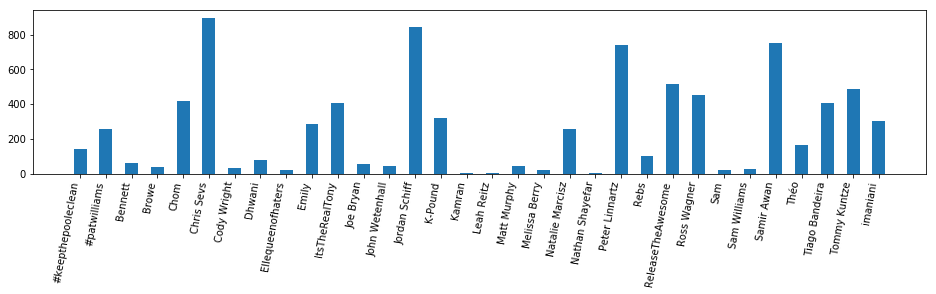

In [2]:
count = records.groupby('name')['timestamp'].agg('count')  

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(111)

ax.bar(x=count.index, height=count.values, width=0.5)
ax.set_xticklabels(labels=count.index, rotation=80, ha='right')

fig.canvas.draw()

## Who's the rooster?

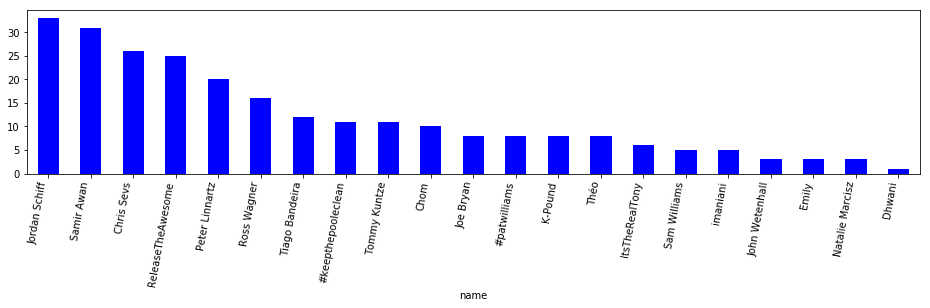

In [212]:
# assume day starts at 5am
adjusted_times = records['timestamp'] + pd.Timedelta(-5, unit='h')
first_times = adjusted_times.groupby(records.index.date).min().values + pd.Timedelta(5, unit='h')
first_messages = records.loc[first_times]
first_count = first_messages.groupby('name')['timestamp'].count()
sorted_first_count = first_count.sort_values(ascending=False)

ax = sorted_first_count.plot(kind='bar', rot=80, figsize=(16, 3), color='b')
ax = ax.set_xticklabels(ax.get_xticklabels(), ha='right')

### Run some text metrics

In [196]:
records['birthday'] = 0
records['bad_words'] = 0
records['photo'] = 0
records['sticker'] = 0
records['exclaimation'] = 0
records['reconstructed_sentence'] = ''

with open('badwords.txt', 'r') as f:
    bad_words = f.readlines()
bad_words = [word.strip().lower() for word in bad_words]

names = {}
for timestamp, row in records.iterrows():
    name = row['name']
    text = row['text'].lower()
    if not name in names:
        names[name] = {'first': {}, 'any': {}, 'end': {}}
        
    words = text.split(' ')
    
    bad_word_count = 0
    sticker_count = 0
    photo_count = 0
    
    for i, word in enumerate(words):
        if word.lower() in bad_words:
            bad_word_count += 1   
        elif word.startswith('(') and word.endswith(')'):
            sticker_count += 1
        elif word == '[sticker]':
            sticker_count += 1
        elif word in ['[photo]', '[video]']:
            photo_count += 1
            
        # make markov map
        if i >= 2:
            prefix = (words[i-2], words[i-1])
            
            if prefix not in names[name]['any']:
                names[name]['any'][prefix] = []
            if word not in names[name]['any'][prefix]:
                names[name]['any'][prefix].extend([word])
                
            if i == 2:
                if prefix not in names[name]['first']:
                    names[name]['first'][prefix] = []
                if word not in names[name]['first'][prefix]:
                    names[name]['first'][prefix].extend([word])
                
            if i == len(words)-1:
                if prefix not in names[name]['end']:
                    names[name]['end'][prefix] = []
                if word not in names[name]['end'][prefix]:
                    names[name]['end'][prefix].extend([word])
            
    records.set_value(timestamp, 'birthday', text.lower().count('birth')) 
    records.set_value(timestamp, 'bad_words', bad_word_count)
    records.set_value(timestamp, 'sticker', sticker_count)
    records.set_value(timestamp, 'photo', photo_count)
    records.set_value(timestamp, 'exclaimation', text.count('!'))
    records.set_value(timestamp, 'reconstructed_sentence', ' '.join(words))

### Hyroglyphic award

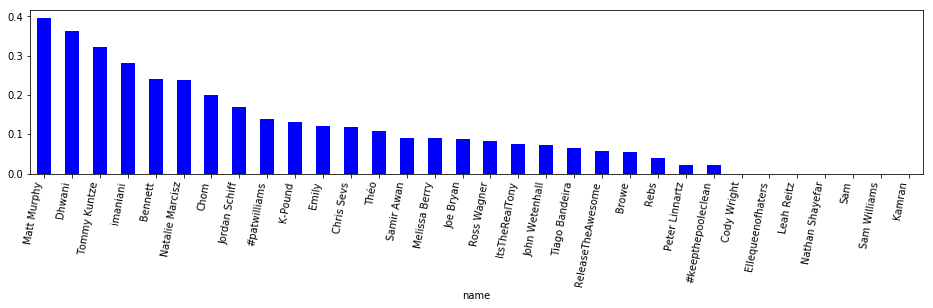

In [213]:
sticker_count = records.groupby('name')['sticker'].agg('sum')

sticker_rate = sticker_count / count
sticker_rate = sticker_rate.sort_values(ascending=False)

ax = sticker_rate.plot(kind='bar', rot=80, figsize=(16, 3), color='b')
ax = ax.set_xticklabels(ax.get_xticklabels(), ha='right')

### Potty-mouth award

In [245]:
text_only = records.copy()
text_only = text_only[text_only['sticker'] == 0]
text_only = text_only[text_only['photo'] == 0]
text_count = text_only.groupby('name')['timestamp'].agg('count')

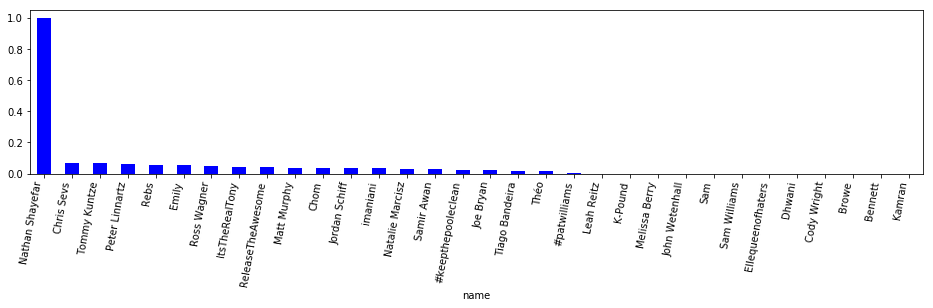

In [246]:
swear_count = text_only.groupby('name')['bad_words'].agg('sum')

swear_rate = swear_count / text_count
swear_rate = swear_rate.sort_values(ascending=False)

ax = swear_rate.plot(kind='bar', rot=80, figsize=(16, 3), color='b')
ax = ax.set_xticklabels(ax.get_xticklabels(), ha='right')

In [239]:
print(text_only[text_only['name'] == 'Nathan Shayefar']['text'])

timestamp
2017-06-28 23:06:00.028000-07:00    Fuck birds 
Name: text, dtype: object


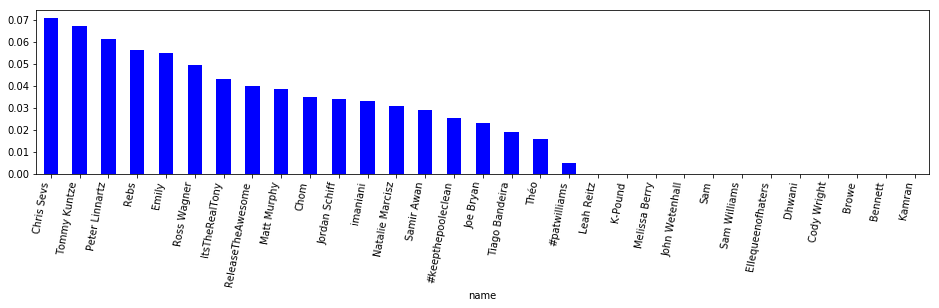

In [247]:
swear_rate = swear_rate.drop('Nathan Shayefar')

ax = swear_rate.plot(kind='bar', rot=80, figsize=(16, 3), color='b')
ax = ax.set_xticklabels(ax.get_xticklabels(), ha='right')

### Excitement award

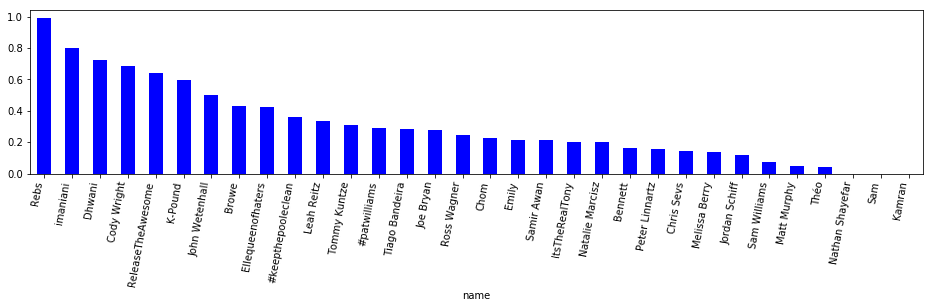

In [250]:
exclaim_count = records.groupby('name')['exclaimation'].agg('sum')

exclaim_rate = exclaim_count / count
exclaim_rate = exclaim_rate.sort_values(ascending=False)

ax = exclaim_rate.plot(kind='bar', rot=80, figsize=(16, 3), color='b')
ax = ax.set_xticklabels(ax.get_xticklabels(), ha='right')

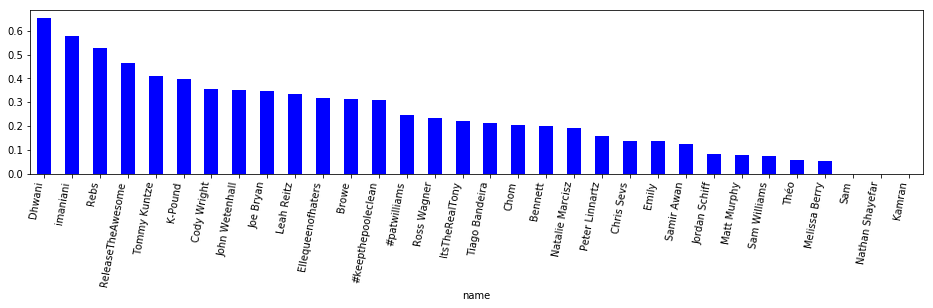

In [249]:
records['exclaim_exists'] = records['exclaimation'] > 0
exclaim_count = records.groupby('name')['exclaim_exists'].agg('sum')

exclaim_rate = exclaim_count / text_count
exclaim_rate = exclaim_rate.sort_values(ascending=False)

ax = exclaim_rate.plot(kind='bar', rot=80, figsize=(16, 3), color='b')
ax = ax.set_xticklabels(ax.get_xticklabels(), ha='right')

### Happiest Birthday

In [272]:
birthday = records[(records['birthday'] > 0) & (records.index.hour > 5)]
first_times = birthday.groupby(birthday.index.date)['timestamp'].agg('min')
first_messages = records.loc[first_times]

first_count = first_messages.groupby('name')['timestamp'].count()
sorted_first_count = first_count.sort_values(ascending=False)

ax = sorted_first_count.plot(kind='bar', rot=80, figsize=(16, 3), color='b')

2017-02-24   2017-02-24 09:50:00.037000-08:00
2017-02-25   2017-02-25 10:02:00.012000-08:00
2017-03-19          2017-03-19 09:53:00-07:00
2017-03-20   2017-03-20 10:19:00.005000-07:00
2017-03-23   2017-03-23 08:31:00.009000-07:00
2017-04-13   2017-04-13 08:00:00.009000-07:00
2017-04-20   2017-04-20 15:59:00.037000-07:00
2017-04-22          2017-04-22 20:33:00-07:00
2017-04-25          2017-04-25 07:38:00-07:00
2017-05-22   2017-05-22 08:31:00.008000-07:00
2017-06-01          2017-06-01 08:21:00-07:00
2017-06-04          2017-06-04 08:22:00-07:00
2017-06-05   2017-06-05 11:40:00.004000-07:00
2017-06-24   2017-06-24 22:28:00.013000-07:00
2017-06-25   2017-06-25 09:12:00.002000-07:00
2017-07-20   2017-07-20 09:30:00.001000-07:00
2017-09-17   2017-09-17 07:14:00.001000-07:00
2017-10-27          2017-10-27 09:21:00-07:00
Name: timestamp, dtype: datetime64[ns, US/Pacific]

### Markov sentence generator

In [198]:
def choose_element(l):
    return l[randint(0, len(l)-1)]

def make_markov(name):
    for attempt in range(10):
        sentence = []
        first_choices = list(names[name]['first'].keys())
        sentence = list(choose_element(first_choices))

        key = (sentence[-2], sentence[-1])
        next_choices = names[name]['first'][key]
        sentence.append(choose_element(next_choices))

        for _ in range(50):
            # break if last key was end of sentence
            if key in names[name]['end']:
                break

            key = (sentence[-2], sentence[-1])
            try:
                next_choices = names[name]['any'][key]
            except:
                print(sentence)
                print(key)
            sentence.append(choose_element(next_choices))

        parsed_sentence = ' '.join(sentence)
        if parsed_sentence not in records['reconstructed_sentence']:
            return parsed_sentence
    
    return parsed_sentence
    

In [276]:
name = 'Jordan Schiff'
make_markov(name)

"wahoo! i'll confirm later via email. i think i'm going next weekend. supposed to be down"

![](images/Jordan.png "")

![](images/Natalie.png "")

![](images/Peter2.png "")

![](images/Rebs.png "")

![](images/Sevs.png "")